In [1]:
import matplotlib
import matplotlib.pyplot as plt


matplotlib.rc("xtick", labelsize=27)
matplotlib.rc("ytick", labelsize=27)
matplotlib.rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
matplotlib.rc("text", usetex=True)


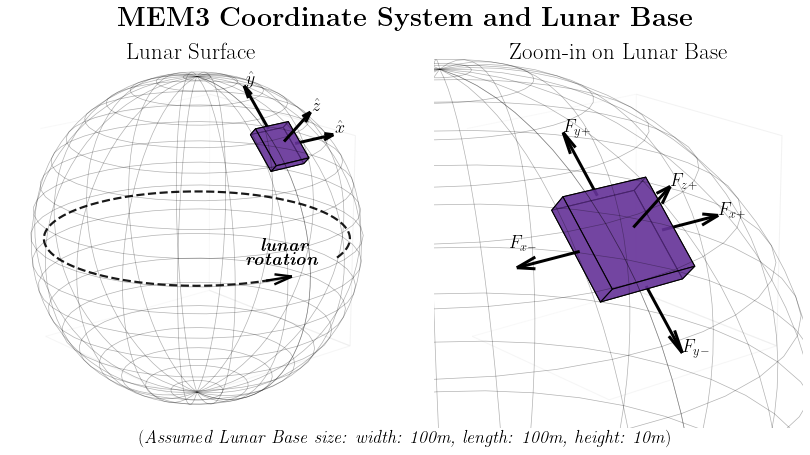

Saved to: lunar_base_schematic.pdf


In [61]:
# Two-panel lunar base flux diagram (clean, publication-ready)
# - Left: full Moon + base
# - Right: zoom near base
# Styling:
#   * Sphere lines: black, higher alpha
#   * Base: light-grey faces, black edges
#   * No grid, ticks, numbers, or pane shading
#   * No phi/theta annotations
# Adjust parameters in the "User parameters" section.

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# ---------------- User parameters ----------------
R_moon = 1.0            # Moon radius (use 1737000 for meters)
h, l, w = 0.06, 0.25, 0.25  # Base height, length(x/east), width(y/north)
phi0_deg, theta0_deg = 45.0, 0.0  # Base location: latitude, longitude (deg)
sphere_resolution = 40   # Sphere wireframe detail
arrow_len = 0.18         # Flux arrow length (relative to base size)
arrow_offset = 0.02      # Lift arrows slightly off the surface
zoom_pad = 0.12          # Extra padding for zoom bounds
elev_deg, azim_deg = 18, -40  # Camera angles
out_path = "lunar_base_schematic.pdf"
# -------------------------------------------------

# -- Helpers: spherical to Cartesian and local frame --
phi0 = np.deg2rad(phi0_deg)
theta0 = np.deg2rad(theta0_deg)

def sph_to_cart(R, phi, theta):
    return np.array([
        R * np.cos(phi) * np.cos(theta),
        R * np.cos(phi) * np.sin(theta),
        R * np.sin(phi),
    ])

# Surface point and local axes (ex=east, ey=north, ez=outward normal)
p = sph_to_cart(R_moon, phi0, theta0)
ez = p / np.linalg.norm(p)
e_east = np.array([-np.sin(theta0), np.cos(theta0), 0.0])
e_north = np.array([
    -np.sin(phi0)*np.cos(theta0),
    -np.sin(phi0)*np.sin(theta0),
     np.cos(phi0),
])
ex = e_east / np.linalg.norm(e_east)
ey = e_north / np.linalg.norm(e_north)

# Base corners
half_l, half_w = l/2.0, w/2.0
bottom = [
    p + (+half_l)*ex + (+half_w)*ey,
    p + (-half_l)*ex + (+half_w)*ey,
    p + (-half_l)*ex + (-half_w)*ey,
    p + (+half_l)*ex + (-half_w)*ey,
]
top = [c + h*ez for c in bottom]

# Mid-height center of the prism (along f_z):
base_center = p + (h/2) * ez

# Arrow origins (face centers)
center_top     = p + h*ez
center_x_plus  = p + (+half_l)*ex
center_x_minus = p + (-half_l)*ex
center_y_plus  = p + (+half_w)*ey         
center_y_minus = p + (-half_w)*ey


# -- Drawing helpers --
def draw_sphere(ax):
    u = np.linspace(0, 2*np.pi, sphere_resolution)
    v = np.linspace(-np.pi/2, np.pi/2, sphere_resolution)
    uu, vv = np.meshgrid(u, v)
    xs = R_moon * np.cos(vv) * np.cos(uu)
    ys = R_moon * np.cos(vv) * np.sin(uu)
    zs = R_moon * np.sin(vv)
    ax.plot_wireframe(xs, ys, zs, rstride=2, cstride=2,
                      linewidth=0.7, alpha=0.3, color="black")

def draw_base(ax):
    # 6 faces of the prism
    verts = [
        [bottom[0], bottom[1], bottom[2], bottom[3]],  # bottom
        [top[0], top[1], top[2], top[3]],              # top
        [bottom[0], bottom[1], top[1], top[0]],
        [bottom[1], bottom[2], top[2], top[1]],
        [bottom[2], bottom[3], top[3], top[2]],
        [bottom[3], bottom[0], top[0], top[3]],
    ]
    poly = Poly3DCollection(verts, facecolors='rebeccapurple',
                            edgecolors="black", linewidths=1.0)
    poly.set_alpha(0.7)
    ax.add_collection3d(poly)

import matplotlib.patheffects as pe

def _label(ax, xyz, text, fontsize=16, zorder=200):
    ax.text(
        xyz[0], xyz[1], xyz[2], text,
        fontsize=fontsize, zorder=zorder,
        #bbox=dict(boxstyle="round,pad=0.18", fc="white", ec="none", alpha=0.85)
    )

def draw_arrow_full(ax, origin, direction, length, label, lw=3):
    """Arrows for the Full Moon panel: longer, always in front, readable label."""
    o = origin + arrow_offset * ez 
    d = direction / np.linalg.norm(direction) * length
    q = ax.quiver(
        o[0], o[1], o[2], d[0], d[1], d[2],
        arrow_length_ratio=0.25, linewidth=lw, color="black", zorder=150
    )
    tip = o + d
    # Slight radial nudge for label clarity
    _label(ax, tip + 0.02*ez, label, fontsize=18, zorder=200)

def draw_arrow_zoom(ax, origin, direction, length, label): 
    o = origin + arrow_offset * ez 
    d = direction / np.linalg.norm(direction) * length 
    ax.quiver(o[0], o[1], o[2], d[0], d[1], d[2], 
              arrow_length_ratio=0.3, linewidth=3, color="black", zorder=100) 
    tip = o + d 
    ax.text(tip[0], tip[1], tip[2], label, fontsize=18)
    
def draw_arrow_zoom2(ax, origin, direction, length, label): 
    o = origin + arrow_offset * ez 
    d = direction / np.linalg.norm(direction) * length 
    ax.quiver(o[0], o[1], o[2], d[0], d[1], d[2], 
              arrow_length_ratio=0.3, linewidth=3, color="black", zorder=100) 
    tip = o + d 
    ax.text(tip[0], tip[1]-.02, tip[2]+.05, label, fontsize=18)


def clean_axes(ax):
    ax.grid(False)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([])
    ax.set_xlabel(""); ax.set_ylabel(""); ax.set_zlabel("")
    # Remove shaded panes & axis lines
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    # Hide the axis spines (works across MPL versions)
    try:
        ax.xaxis.line.set_color((1,1,1,0))
        ax.yaxis.line.set_color((1,1,1,0))
        ax.zaxis.line.set_color((1,1,1,0))
    except Exception:
        pass
    
def equalize_3d_axes(ax):
    """Force x, y, z to have the same span so spheres look round."""
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()

    xmid = 0.5 * (xlim[0] + xlim[1])
    ymid = 0.5 * (ylim[0] + ylim[1])
    zmid = 0.5 * (zlim[0] + zlim[1])

    r = max(
        0.5 * (xlim[1] - xlim[0]),
        0.5 * (ylim[1] - ylim[0]),
        0.5 * (zlim[1] - zlim[0]),
    )

    ax.set_xlim3d(xmid - r, xmid + r)
    ax.set_ylim3d(ymid - r, ymid + r)
    ax.set_zlim3d(zmid - r, zmid + r)

    # If your Matplotlib is 3.3+, this also helps:
    try:
        ax.set_box_aspect([1, 1, 1])
    except Exception:
        pass

# -- Build the figure --
fig = plt.figure(figsize=(12, 6))

# Left: Full Moon
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
draw_sphere(ax1); draw_base(ax1)

# Make full-panel arrows longer than the zoom-panel ones
arrow_len_full = 1.2 * max(l, w, h)   # tweak the 1.2 factor to taste

for origin, direction, label in [
    (center_x_plus,  ex, r"$\hat{x}$"),
    (center_y_plus,  ey, r"$\hat{y}$"),
    (center_top,     ez, r"$\hat{z}$"),
]:
    draw_arrow_full(ax1, origin, direction, arrow_len_full, label)
ax1.view_init(elev=elev_deg, azim=azim_deg)
m = 0.6 * (R_moon + h)
ax1.set_xlim(-m, m); ax1.set_ylim(-m, m); ax1.set_zlim(-m, m)
equalize_3d_axes(ax1)             
ax1.set_title("Lunar Surface", fontsize=23, y=1.07)



def draw_midplane_rotation_arrow(ax, radius=0.95*R_moon, angle=1.7*np.pi,
                                 phase=0.0, z_lift=0.02*R_moon,
                                 lw=2.2):
    """
    Draw a CCW curved arrow in the midplane (phi=0, z≈0).
    - radius: arrow circle radius
    - angle: total sweep (radians), >π looks nicer
    - phase: where the arc starts (radians, 0 at +x, CCW increases)
    - z_lift: small lift above z=0 so it doesn't collide with the wireframe
    """
    n = 220
    theta = np.linspace(phase, phase + angle, n)
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    z = np.full_like(theta, z_lift)     # sit slightly above the midplane

    # Curved arc (CCW because theta increases)
    ax.plot(x, y, z, linestyle="--", linewidth=lw, color="black", alpha=0.9, zorder=180)

    # Arrowhead as a short tangent quiver at the end of the arc
    p_tail = np.array([x[-2], y[-2], z[-2]])
    p_tip  = np.array([x[-1], y[-1], z[-1]])
    t = p_tip - p_tail
    t = t / np.linalg.norm(t) * (0.18 * radius)  # head length relative to radius

    ax.quiver(
        p_tail[0], p_tail[1], p_tail[2],
        t[0], t[1], t[2],
        arrow_length_ratio=0.7, linewidth=lw+0.2, color="black", zorder=200
    )



    # Place text just above the arrow tip
    text_offset = 0.1 * radius  # small offset for visibility
    text_pos = p_tip + np.array([0.0, text_offset, .07])  # offset in +y direction

    ax.text(text_pos[0], text_pos[1], text_pos[2],
            r"\textbf{\textit{lunar}}\\\textbf{\textit{rotation}}",
            ha="center", va="bottom", fontsize=18)


# CCW midplane (phi=0) rotation arrow
draw_midplane_rotation_arrow(
    ax1,
    radius=0.92*R_moon,    # slightly inside the sphere edge
    angle=1.8*np.pi,       # nice long sweep
    phase=np.pi/8,         # rotate where the arc lives around the equator
    z_lift=0.02*R_moon     # keeps it clean above the wireframe
)


clean_axes(ax1)

# Right: Zoom near base
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
draw_sphere(ax2); draw_base(ax2)
for origin, direction, label in [
    (center_x_plus,  ex, r"$F_{x+}$"),
    (center_x_minus, -ex, r"$F_{x-}$"),
    (center_y_plus,  ey, r"$F_{y+}$"),
    (center_y_minus, -ey, r"$F_{y-}$"),
    (center_top,     ez, r"$F_{z+}$"),
]:
    if label != r"$F_{x-}$":
        draw_arrow_zoom(ax2, origin, direction, arrow_len, label)
    else:
        draw_arrow_zoom2(ax2, origin, direction, arrow_len, label)
        
ax2.view_init(elev=elev_deg, azim=azim_deg)
corners = np.array(bottom + top)
cx, cy, cz = corners[:,0], corners[:,1], corners[:,2]
ax2.set_xlim(cx.min()-zoom_pad, cx.max()+zoom_pad)
ax2.set_ylim(cy.min()-zoom_pad, cy.max()+zoom_pad)
ax2.set_zlim(cz.min()-zoom_pad, cz.max()+zoom_pad)
equalize_3d_axes(ax2)             
ax2.set_title("Zoom-in on Lunar Base", fontsize=23, y=1.07)

clean_axes(ax2)

fig.suptitle(r"\textbf{MEM3 Coordinate System and Lunar Base}", fontsize=27, y=1.)
fig.text(0.5, 0.0, r"$(\textit{Assumed Lunar Base size: width: 100m, length: 100m, height: 10m})$",
         ha="center", va="center", fontsize=18, style="italic")

plt.tight_layout()
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Saved to: {out_path}")